# Effect of instantaneous weather sampling rate on subhourly clipping errors - SURFRAD
These notebooks resample the SURFRAD network data at different frequencies to simulate satellite data.

In [1]:
import calendar
import pathlib
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import rdtools
import seaborn as sns

# mpl.rcParams['figure.figsize'] = (16, 10)
# sns.set() should be last or only call in this cell?
sns.set(font_scale=1.5, rc={'figure.figsize': (16, 10)})

In [2]:
# CONSTANTS
DAYMINUTES = 24*60
KELVINS = 273.15
MAX_GHI_RATIO = 1.5

## Some useful functions
* `read_surfrad_year` just reads all daily files from a yearly surfrad folder
* ~`estimate_air_temp` is for years that have incomplete air temperature data like 1995.~ No we don't need this since filtering on data completness.

In [3]:
def read_surfrad_year(surfrad_year_path):
    """
    Parameters
    -----------
    surfrad_year_path : pathlib.Path
        path to folder containing a single year of daily SURFRAD data files
    Returns
    -------
    df : pandas.DataFrame
        All of the daily weather data from folder of single year concatentated
        along time axis
    header : dict
        info about the location, timezone, and station name
    """
    data = [pvlib.iotools.read_surfrad(f) for f in surfrad_year_path.iterdir()]
    dfs, heads = zip(*data)
    df = pd.concat(dfs)
    header = heads[0]
    return df, header

## Accessing SURFRAD data
SURFRAD has 7 stations. pvlib-python has functions to download data from SURFRAD, but it takes a while, so I have previously downloaded and cached the data in folders for each station. Inside each station folder, there are folders for each year with data. Most stations began measurements in 1995 and continuously add new data one day at a time. These daily data files are stored in the yearly folders.

Here I specify the path the SURFRAD folder that contains all of the stations and then pick a single station to look at in this folder. Later we can try to manipulate all of the stations after working out the algorithms.

In [4]:
# specify path to all SURFRAD station data
surfrad_dir = pathlib.Path('../../SURFRAD')
print(f'Is there really a \33[1m\33[91m"SURFRAD"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{surfrad_dir.exists()} \u2713\33[0m\33[0m')

Is there really a "SURFRAD" directory? True ✓


In [5]:
# specify path to just a single station, EG: Bondville, IL
weather_dir = "Bondville_IL"
weather_path = surfrad_dir / weather_dir
print(f'Is there really a \33[1m\33[91m"{weather_path}"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{weather_path.exists()} \u2713\33[0m\33[0m')

Is there really a "..\..\SURFRAD\Bondville_IL" directory? True ✓


In [6]:
# display what years are in the SURFRAD station folder
weather_year_paths = weather_path.iterdir()
years = [p.parts[-1] for p in weather_year_paths]
', '.join(years)

'1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021'

## Narrowing Selection
There are a lot of years in a single station because SURFRAD has been operating for over 25 years! We can narrow our selection and make our work easier by checking:
* timestep or time-interval
* completeness of the year
* containing all of the required data

### Timesteps
SURFRAD stations collect data at either 3-minute or 1-minute intervals. For example, up until 2009, the Bondville, IL, station collected data at 3-minute intervals and then afterwards colected at 1-minute intervals. I narrow the selection by only using 1-minute intervals.

### Yearly Completeness
Each year has missing data, so I further narrow the selection by only using years that are at least 98% complete.

### Data Fields
Some of the fields are also missing. For example 1995 is missing all of the diffuse horizontal irradiance and about half of the air temperature data. I further narrow the selection by only using years with GHI, DHI, DNI, air temperature, wind speed, and solar zenith. This is a complete data set.

In [7]:
# how many years are missing data?
REQD_COLS = ['ghi', 'dhi', 'dni', 'solar_zenith', 'wind_speed', 'temp_air']
weather_years = dict.fromkeys(years)
weather_stats = pd.DataFrame(index=years, columns=['Number of Records', 'Expected', 'Timestep', 'Completeness'])
for weather_year in weather_path.iterdir():
    weather_df, weather_header = read_surfrad_year(weather_year)
    year = weather_year.parts[-1]
    dt = np.diff(weather_df.index).min().seconds/60
    weather_years[year] = weather_df[REQD_COLS].dropna()
    num_recs = weather_years[year].shape[0]
    daze = 365*24*60/dt
    if calendar.isleap(int(year)):
        daze += (24*60/dt)
    frac_recs = num_recs/daze
    weather_stats.loc[year] = (num_recs, daze, dt, frac_recs)
    print(f'{year} has {num_recs} out of {daze} expected with {dt}-min timestep (year complete = {frac_recs*100:g}%)')
print(weather_header)
weather_stats

1995 has 0 out of 175200.0 expected with 3.0-min timestep (year complete = 0%)
1996 has 56460 out of 175680.0 expected with 3.0-min timestep (year complete = 32.138%)
1997 has 126687 out of 175200.0 expected with 3.0-min timestep (year complete = 72.3099%)
1998 has 173314 out of 175200.0 expected with 3.0-min timestep (year complete = 98.9235%)
1999 has 116761 out of 175200.0 expected with 3.0-min timestep (year complete = 66.6444%)
2000 has 174125 out of 175680.0 expected with 3.0-min timestep (year complete = 99.1149%)
2001 has 174752 out of 175200.0 expected with 3.0-min timestep (year complete = 99.7443%)
2002 has 172037 out of 175200.0 expected with 3.0-min timestep (year complete = 98.1946%)
2003 has 174462 out of 175200.0 expected with 3.0-min timestep (year complete = 99.5788%)
2004 has 174274 out of 175680.0 expected with 3.0-min timestep (year complete = 99.1997%)
2005 has 171538 out of 175200.0 expected with 3.0-min timestep (year complete = 97.9098%)
2006 has 165021 out of 

,Number of Records,Expected,Timestep,Completeness
1995,0,175200.0,3.0,0.0
1996,56460,175680.0,3.0,0.32138
1997,126687,175200.0,3.0,0.723099
1998,173314,175200.0,3.0,0.989235
1999,116761,175200.0,3.0,0.666444
2000,174125,175680.0,3.0,0.991149
2001,174752,175200.0,3.0,0.997443
2002,172037,175200.0,3.0,0.981946
2003,174462,175200.0,3.0,0.995788
2004,174274,175680.0,3.0,0.991997


In [8]:
weather_header

{'name': 'Bondville',
 'latitude': 40.05,
 'longitude': -88.37,
 'elevation': 213.0,
 'surfrad_version': 1,
 'tz': 'UTC'}

## QA/QC
Selecting only years that are > 98% complete and have 1-minute timestep, we reduce the number of years to 8: from 2010-2015, 2017, 2019

In [9]:
is_dt_1min = (weather_stats['Timestep'].values.astype(int) == 1)
is_98pct_complete = (weather_stats['Completeness'].values >= 0.98)
selected_years = weather_stats[is_dt_1min & is_98pct_complete]
selected_years

,Number of Records,Expected,Timestep,Completeness
2010,522545,525600.0,1.0,0.994188
2011,523493,525600.0,1.0,0.995991
2012,525658,527040.0,1.0,0.997378
2013,520918,525600.0,1.0,0.991092
2014,522963,525600.0,1.0,0.994983
2015,522006,525600.0,1.0,0.993162
2017,520497,525600.0,1.0,0.990291
2019,518692,525600.0,1.0,0.986857


making plot of ghi for 2010
making plot of ghi for 2011
making plot of ghi for 2012
making plot of ghi for 2013
making plot of ghi for 2014
making plot of ghi for 2015
making plot of ghi for 2017
making plot of ghi for 2019
making plot of dhi for 2010
making plot of dhi for 2011
making plot of dhi for 2012
making plot of dhi for 2013
making plot of dhi for 2014
making plot of dhi for 2015
making plot of dhi for 2017
making plot of dhi for 2019
making plot of dni for 2010
making plot of dni for 2011
making plot of dni for 2012
making plot of dni for 2013
making plot of dni for 2014
making plot of dni for 2015
making plot of dni for 2017
making plot of dni for 2019
making plot of solar_zenith for 2010
making plot of solar_zenith for 2011
making plot of solar_zenith for 2012
making plot of solar_zenith for 2013
making plot of solar_zenith for 2014
making plot of solar_zenith for 2015
making plot of solar_zenith for 2017
making plot of solar_zenith for 2019
making plot of wind_speed for 20

Text(0.5, 0.98, 'Selected SURFRAD data for Bondville_IL')

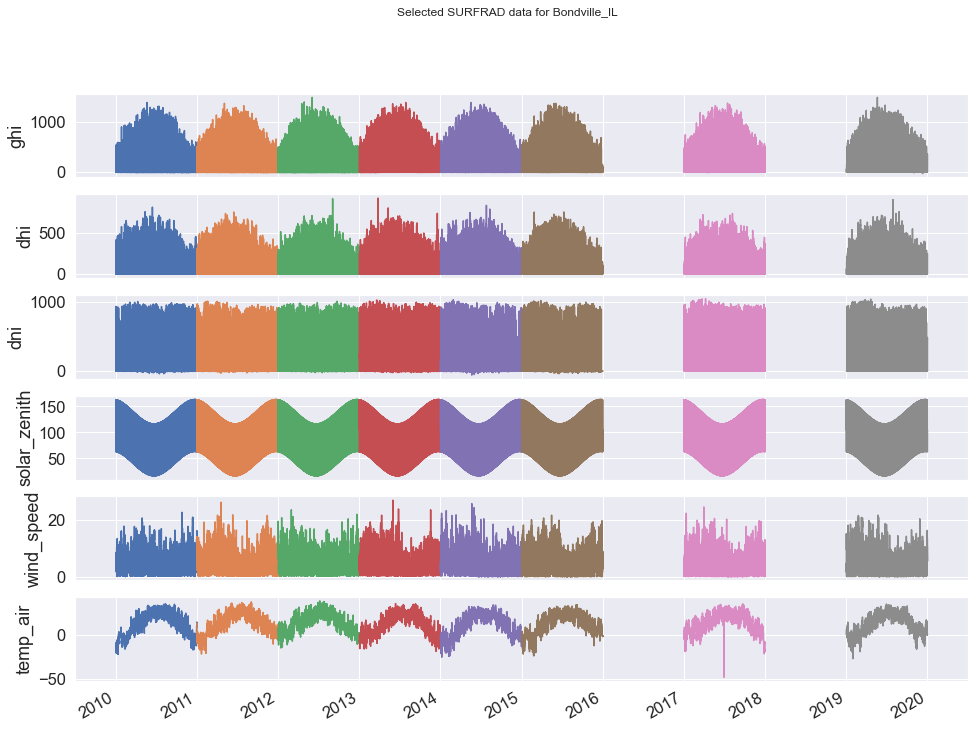

In [10]:
f, ax = plt.subplots(6, 1, sharex=True, figsize=(16, 12))
for n, k in enumerate(REQD_COLS):
    for year in selected_years.index:
        print(f'making plot of {k} for {year}')
        weather_years[year][k].plot(ax=ax[n])
    ax[n].set_ylabel(k)
f.suptitle(f'Selected SURFRAD data for {weather_dir}')

In [11]:
# pop the unselected years from weather_years
for year in years:
    if year not in selected_years.index:
        print(f'{year}: {weather_stats.loc[year, "Completeness"]} complete and {weather_stats.loc[year, "Timestep"]}-min timestep')
        weather_years.pop(year)
list(weather_years.keys())

1995: 0.0 complete and 3.0-min timestep
1996: 0.321379781420765 complete and 3.0-min timestep
1997: 0.7230993150684931 complete and 3.0-min timestep
1998: 0.9892351598173516 complete and 3.0-min timestep
1999: 0.6664440639269407 complete and 3.0-min timestep
2000: 0.991148679417122 complete and 3.0-min timestep
2001: 0.9974429223744292 complete and 3.0-min timestep
2002: 0.9819463470319635 complete and 3.0-min timestep
2003: 0.9957876712328767 complete and 3.0-min timestep
2004: 0.9919968123861567 complete and 3.0-min timestep
2005: 0.9790981735159817 complete and 3.0-min timestep
2006: 0.9419006849315068 complete and 3.0-min timestep
2007: 0.996541095890411 complete and 3.0-min timestep
2008: 0.9952811930783242 complete and 3.0-min timestep
2009: 0.9672831050228311 complete and 1.0-min timestep
2016: 0.9741822252580449 complete and 1.0-min timestep
2018: 0.9788337138508372 complete and 1.0-min timestep
2020: 0.9125265634486946 complete and 1.0-min timestep
2021: 0.07500380517503805 co

['2010', '2011', '2012', '2013', '2014', '2015', '2017', '2019']

In [12]:
LATITUDE = weather_header['latitude']
LONGITUDE = weather_header['longitude']
ELEVATION = weather_header['elevation']
YEAR = '2010'
TIMES = weather_years[YEAR].index

In [13]:
TIMES

DatetimeIndex(['2010-01-01 00:00:00+00:00', '2010-01-01 00:01:00+00:00',
               '2010-01-01 00:02:00+00:00', '2010-01-01 00:03:00+00:00',
               '2010-01-01 00:04:00+00:00', '2010-01-01 00:05:00+00:00',
               '2010-01-01 00:06:00+00:00', '2010-01-01 00:07:00+00:00',
               '2010-01-01 00:08:00+00:00', '2010-01-01 00:09:00+00:00',
               ...
               '2010-12-31 23:50:00+00:00', '2010-12-31 23:51:00+00:00',
               '2010-12-31 23:52:00+00:00', '2010-12-31 23:53:00+00:00',
               '2010-12-31 23:54:00+00:00', '2010-12-31 23:55:00+00:00',
               '2010-12-31 23:56:00+00:00', '2010-12-31 23:57:00+00:00',
               '2010-12-31 23:58:00+00:00', '2010-12-31 23:59:00+00:00'],
              dtype='datetime64[ns, UTC]', length=522545, freq=None)

In [14]:
df = weather_years[YEAR]
df.head()

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air
2010-01-01 00:00:00+00:00,-4.1,-0.3,0.9,105.07,6.4,-8.9
2010-01-01 00:01:00+00:00,-4.1,-0.3,0.9,105.25,6.5,-8.9
2010-01-01 00:02:00+00:00,-4.1,-0.2,1.0,105.44,6.6,-8.9
2010-01-01 00:03:00+00:00,-4.1,-0.2,0.9,105.62,6.9,-8.9
2010-01-01 00:04:00+00:00,-4.1,-0.3,1.0,105.80,6.7,-8.9


In [15]:
# get solar position
sp = pvlib.solarposition.get_solarposition(
        TIMES, LATITUDE, LONGITUDE)
solar_zenith = sp.apparent_zenith.values

In [16]:
# check the calculated zenith from SURFRAD
ze_mbe = 100 * (
    sum(solar_zenith - df.solar_zenith.values)
    / sum(df.solar_zenith.values))
print(f'zenith MBE: {ze_mbe}%')

zenith MBE: 0.003319169805525714%


## Load SURFRAD daily weather data
Each day is in a separate file. We already read this in using pvlib

In [17]:
# how many days are in this file
weather_year_paths = list(weather_path.iterdir())
day_files = {int(d.parts[-1][5:-4]) for d in weather_year_paths[15].iterdir()}
len(day_files)

365

In [18]:
# missing days
missing_days = set(range(1, 366)) - day_files
missing_days

set()

## Sanity check
Look at a few timestamps around solar noon and display only a handful of columns:
* direct normal irradiance (DNI): `'dni'`
* global horizontal irradiance (GHI): `'ghi'`
* diffuse horizontal irradiance (DHI): `'dhi'`
* solar zenith: `'solar_zenith'`
* wind speed: `'wind_speed'`
* air temperature: `'temp_air'`

In [19]:
# view a few timestamps to sanity check (E. Tufte, ...)
df['2010-07-07T12:09:00-06:00':'2010-07-07T12:18:00-06:00'][REQD_COLS]  # <-- XXX: pick dates for each month

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air
2010-07-07 18:09:00+00:00,1041.0,239.1,820.9,17.64,2.8,32.1
2010-07-07 18:10:00+00:00,1042.7,241.6,820.2,17.67,2.8,32.1
2010-07-07 18:11:00+00:00,1045.5,245.3,820.4,17.70,1.6,32.0
2010-07-07 18:12:00+00:00,1058.2,252.3,827.5,17.73,1.6,32.2
2010-07-07 18:13:00+00:00,1076.7,263.9,834.8,17.76,1.0,32.2
2010-07-07 18:14:00+00:00,1089.5,278.1,834.0,17.80,1.3,32.3
2010-07-07 18:15:00+00:00,1082.0,284.6,821.2,17.84,2.2,32.4
2010-07-07 18:16:00+00:00,1072.6,287.9,807.1,17.88,3.3,32.5
2010-07-07 18:17:00+00:00,1081.6,292.8,805.9,17.92,5.0,32.4
2010-07-07 18:18:00+00:00,1069.9,293.5,793.1,17.97,4.0,32.1


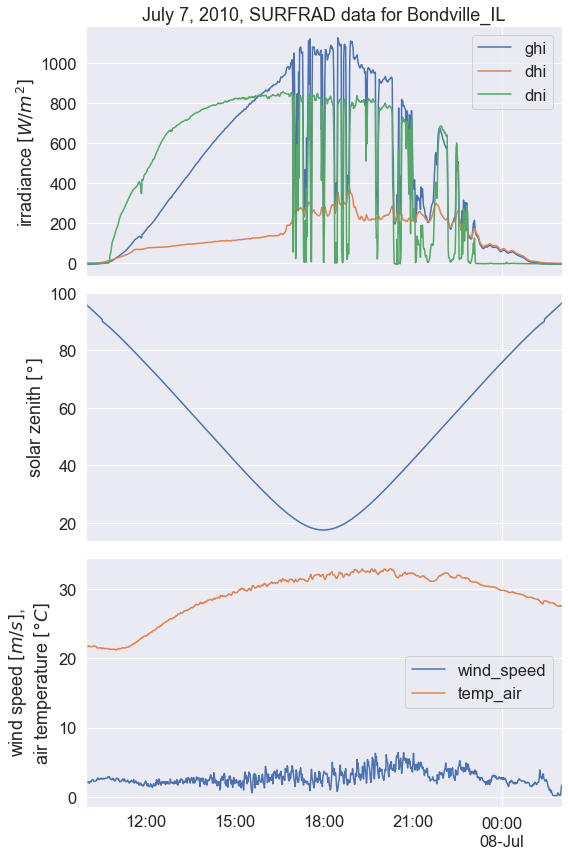

In [20]:
f, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
JULY7_MORN, JULY7_NITE = '2010-07-07T04:00:00-06:00', '2010-07-07T20:00:00-06:00'
df[JULY7_MORN:JULY7_NITE][REQD_COLS[:3]].plot(ax=ax[0])
ax[0].set_title(f'July 7, 2010, SURFRAD data for {weather_dir}')
ax[0].set_ylabel('irradiance $[W/m^2]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[3]].plot(ax=ax[1])
ax[1].set_ylabel('solar zenith $[\degree]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[4:]].plot(ax=ax[2])
ax[2].set_ylabel('wind speed $[m/s]$,\nair temperature $[\degree C]$')
f.tight_layout()

## Data quality
Do some basic quality checking:
1. no irradiance should be negative
2. the DHI has to be the same as
    $$GHI - DNI \cos \left( \theta \right)$$

Then plot a sample day and take a look:

In [22]:
dni = np.maximum(0, df['dni'])
ghi = np.maximum(0, df['ghi'])
dhi = np.maximum(0, df['dhi'])
zerad = np.radians(df['solar_zenith'])
dhi_calc = pd.Series(np.maximum(0, ghi - dni*np.cos(zerad)), name='DHI calc')
irr_check = pd.concat([dni, ghi, dhi, dhi_calc], axis=1)

In [26]:
# check the calculated zenith from SURFRAD
dhi_mbe = 100 * (
    sum(dhi.resample('D').sum() - dhi_calc.resample('D').sum())
    / sum(dhi.resample('D').sum()))
print(f'dhi MBE: {dhi_mbe}%')

dhi MBE: 5.103995698314832%


In [29]:
JAN7_MORN, JAN7_NITE = '2010-01-07T06:00:00-06:00', '2010-01-07T18:00:00-06:00'

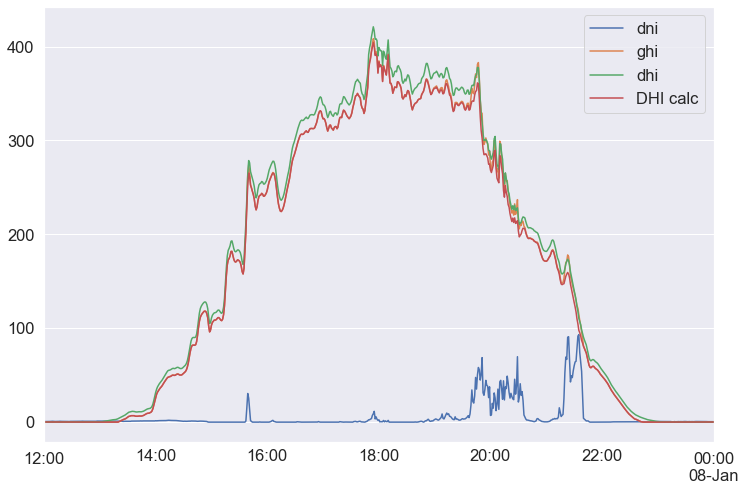

In [30]:
irr_check[JAN7_MORN:JAN7_NITE].plot(figsize=(12, 8))  # <-- XXX: pick dates for each month
plt.legend()

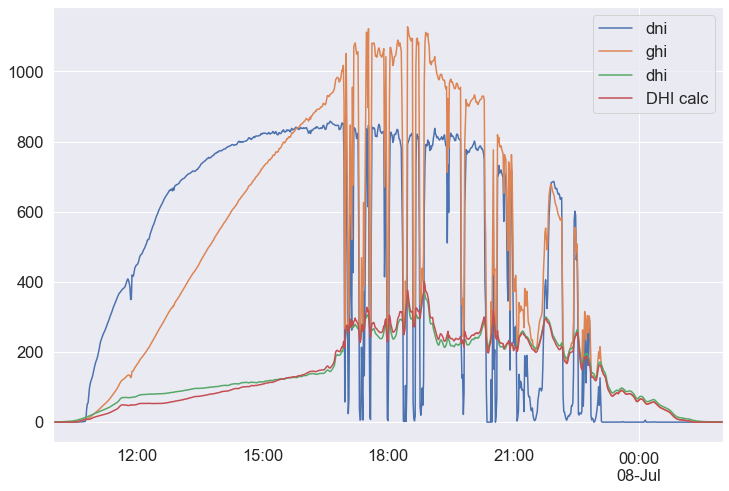

In [28]:
irr_check[JULY7_MORN:JULY7_NITE].plot(figsize=(12, 8))  # <-- XXX: pick dates for each month
plt.legend()

## assembling weather file
To model the output we need the following columns:
1. datetime as ISO8601 but no nanoseconds or timezone
2. GHI
2. DHI
3. Temp
4. WS

In [31]:
# get other parameters needed for modeling like windspeed and air temp
wspd = df['wind_speed']
tair = df['temp_air']

In [32]:
weather = pd.concat([ghi, dni, dhi, tair, wspd], axis=1)
weather.index.name = 'datetime'
weather.columns = ['GHI', 'DNI', 'DHI', 'Temp', 'WS']
weather.head()

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-01 00:00:00+00:00,0.0,0.9,0.0,-8.9,6.4
2010-01-01 00:01:00+00:00,0.0,0.9,0.0,-8.9,6.5
2010-01-01 00:02:00+00:00,0.0,1.0,0.0,-8.9,6.6
2010-01-01 00:03:00+00:00,0.0,0.9,0.0,-8.9,6.9
2010-01-01 00:04:00+00:00,0.0,1.0,0.0,-8.9,6.7


In [33]:
weather.loc['2010-01-01T08:21:00-06:00']  # <-- XXX: pick dates for each month

GHI     127.8
DNI     556.5
DHI      54.1
Temp    -15.5
WS        5.7
Name: 2010-01-01 14:21:00+00:00, dtype: float64

## Simulate 5-minute sampled satellite data
Choose instantaneous records every five minutes. Choose approximately the middle of the 5-minute sampling interval. Since these are 1-minute timestamps already, the closest to the middle is either the 2nd or 3rd minute.

In [34]:
every5min = list(range(2, 60, 5))
every5min

[2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57]

### Shift index
We need the timestamp to be at the start of the sampling interval

In [35]:
weather5inst = weather[weather.index.minute.isin(every5min)].shift(freq='-2min')
weather5inst60min = weather5inst.resample('H').mean()
weather5inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-07 12:00:00+00:00,0.000000,0.841667,0.075000,-6.441667,3.958333
2010-01-07 13:00:00+00:00,4.608333,1.116667,8.125000,-6.225000,3.166667
2010-01-07 14:00:00+00:00,67.225000,1.216667,74.558333,-5.841667,4.716667
2010-01-07 15:00:00+00:00,181.950000,0.250000,192.641667,-8.033333,10.975000
2010-01-07 16:00:00+00:00,281.958333,0.108333,295.550000,-8.925000,11.633333
2010-01-07 17:00:00+00:00,340.616667,0.883333,355.058333,-9.158333,11.300000
2010-01-07 18:00:00+00:00,356.350000,0.516667,372.658333,-10.100000,11.325000
2010-01-07 19:00:00+00:00,342.408333,15.491667,352.933333,-10.808333,11.875000
2010-01-07 20:00:00+00:00,225.133333,18.508333,231.816667,-11.325000,11.300000


## Ditto for every 15-minutes
Repeat for 15 minute intervals. Same dilemma, the closest record to the middle of the interval is either the 7th or 8th minute.

In [36]:
every15min = list(range(7, 60, 15))
every15min

[7, 22, 37, 52]

In [37]:
weather15inst = weather[weather.index.minute.isin(every15min)].shift(freq='-7min')
weather15inst60min = weather15inst.resample('H').mean()
weather15inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-07 12:00:00+00:00,0.000,0.875,0.100,-6.450,3.950
2010-01-07 13:00:00+00:00,4.375,1.075,7.950,-6.225,3.225
2010-01-07 14:00:00+00:00,70.550,1.325,77.900,-5.850,4.450
2010-01-07 15:00:00+00:00,184.325,0.350,194.725,-8.025,10.850
2010-01-07 16:00:00+00:00,284.675,0.200,298.275,-8.950,11.725
2010-01-07 17:00:00+00:00,348.650,1.000,363.125,-9.150,11.225
2010-01-07 18:00:00+00:00,358.625,0.900,374.925,-10.100,11.500
2010-01-07 19:00:00+00:00,333.525,11.725,345.500,-10.800,11.800
2010-01-07 20:00:00+00:00,222.300,14.425,230.325,-11.325,11.525


## Ditto 60-minutes

In [38]:
weather30inst = weather[weather.index.minute.isin([15, 45])].shift(freq='-15min')
weather30inst60min = weather30inst.resample('H').mean()
weather30inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-07 12:00:00+00:00,0.00,0.90,0.10,-6.45,4.05
2010-01-07 13:00:00+00:00,3.30,1.20,6.85,-6.20,3.15
2010-01-07 14:00:00+00:00,70.50,1.40,77.85,-5.85,4.85
2010-01-07 15:00:00+00:00,191.10,0.00,201.80,-8.10,11.05
2010-01-07 16:00:00+00:00,267.60,0.00,280.75,-8.95,11.00
2010-01-07 17:00:00+00:00,322.30,0.00,336.85,-9.20,11.55
2010-01-07 18:00:00+00:00,347.65,0.45,364.60,-10.10,10.55
2010-01-07 19:00:00+00:00,362.15,22.05,370.60,-10.85,10.85
2010-01-07 20:00:00+00:00,221.35,12.30,229.80,-11.30,11.00


# Visual Comparison of different sampling intervals
How do these look compared to each other? Are they shifted correctly? Are they on the same order? Do they capture the variability?

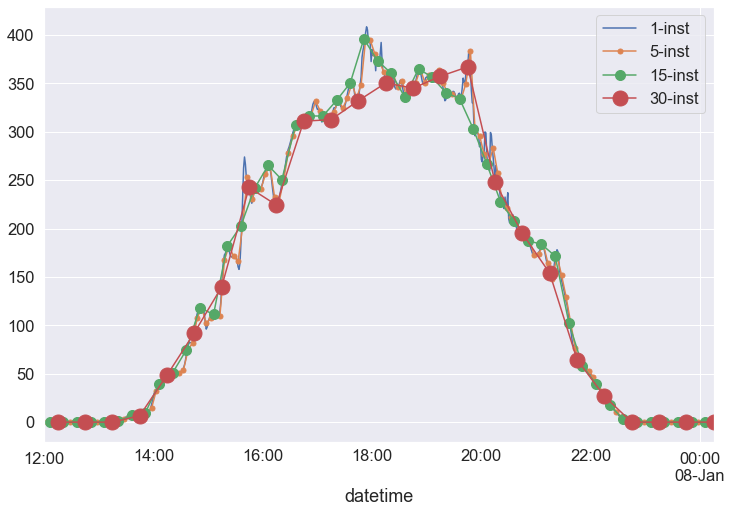

In [39]:
ax = weather[JAN7_MORN:JAN7_NITE]['GHI'].plot(figsize=(12, 8))
weather5inst[JAN7_MORN:JAN7_NITE]['GHI'].shift(freq='3min').plot(ax=ax, marker='o', ms=5)
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].shift(freq='6min').plot(ax=ax, marker='o', ms=10)
weather30inst[JAN7_MORN:JAN7_NITE]['GHI'].shift(freq='15min').plot(ax=ax, marker='o', ms=15)
plt.legend(['1-inst', '5-inst', '15-inst', '30-inst'])

Text(0, 0.5, 'GHI $[W/m^2]$')

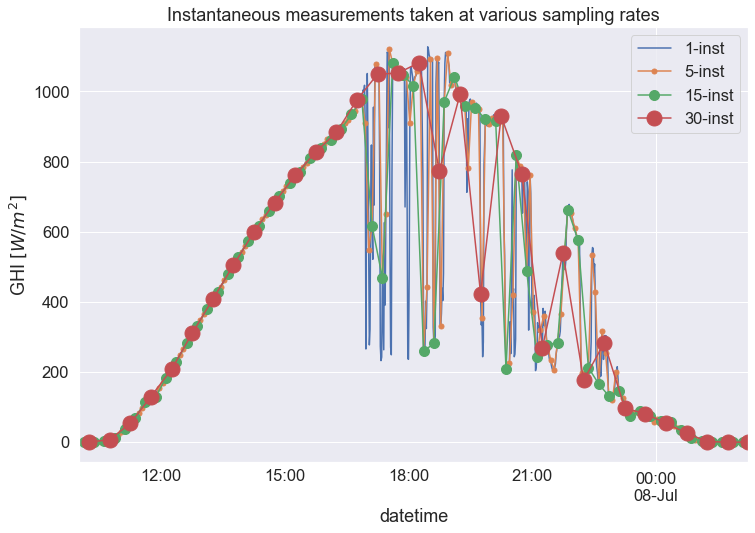

In [40]:
ax = weather[JULY7_MORN:JULY7_NITE]['GHI'].plot(figsize=(12, 8))
weather5inst[JULY7_MORN:JULY7_NITE]['GHI'].shift(freq='2min').plot(ax=ax, marker='o', ms=5)
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].shift(freq='7min').plot(ax=ax, marker='o', ms=10)
weather30inst[JULY7_MORN:JULY7_NITE]['GHI'].shift(freq='15min').plot(ax=ax, marker='o', ms=15)
plt.legend(['1-inst', '5-inst', '15-inst', '30-inst'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

## Hourly averages from instantaneously sampled

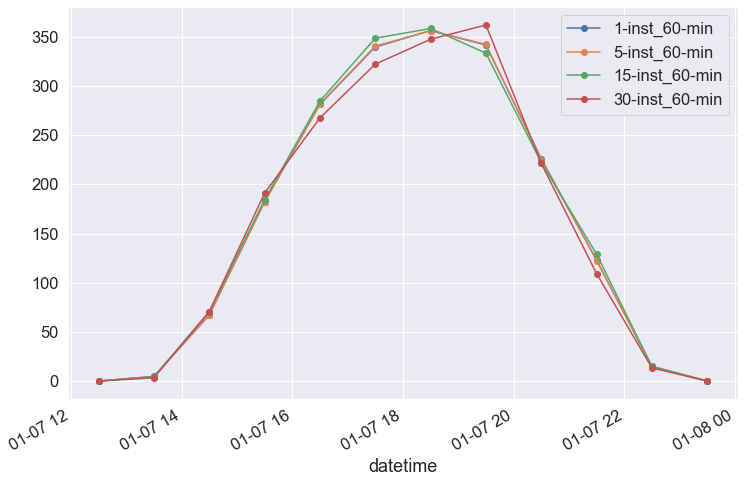

In [41]:
ax = weather.resample('H').mean().shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o', figsize=(12, 8))
weather5inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])

Text(0, 0.5, 'GHI $[W/m^2]$')

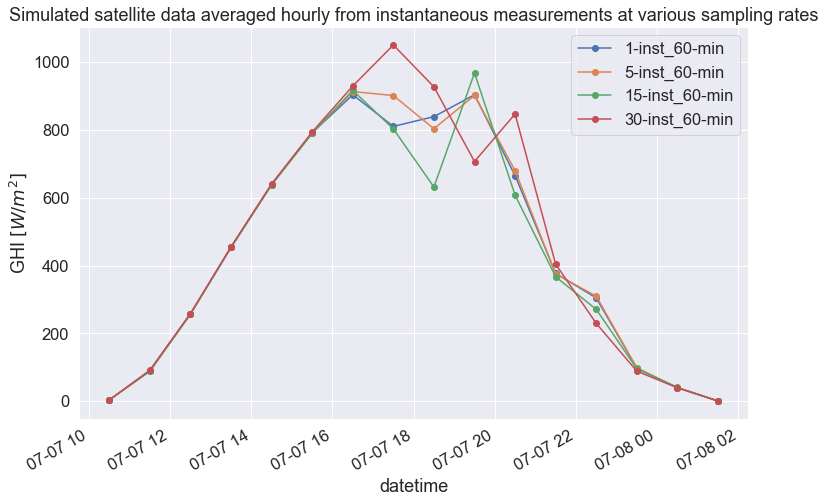

In [42]:
ax = weather.resample('H').mean().shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o', figsize=(12, 8))
weather5inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

In [43]:
weather.resample('H').mean()[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-07 12:00:00+00:00,0.000000,0.840000,0.086667,-6.441667,3.973333
2010-01-07 13:00:00+00:00,4.721667,1.116667,8.226667,-6.223333,3.215000
2010-01-07 14:00:00+00:00,67.176667,1.238333,74.495000,-5.851667,4.738333
2010-01-07 15:00:00+00:00,182.531667,1.481667,192.716667,-8.028333,11.045000
2010-01-07 16:00:00+00:00,281.430000,0.135000,294.993333,-8.926667,11.353333
2010-01-07 17:00:00+00:00,339.815000,1.056667,354.406667,-9.161667,11.286667
2010-01-07 18:00:00+00:00,356.428333,0.530000,372.875000,-10.085000,11.251667
2010-01-07 19:00:00+00:00,341.808333,16.521667,352.003333,-10.825000,11.598333
2010-01-07 20:00:00+00:00,226.126667,18.896667,232.651667,-11.320000,11.081667


## Compare 15-minute time averaged to 15-minute instantaneous
How do shorter sampling intervals compare to time averaged values? Starting with 1-minute data, average every 15-minutes and compare to picking a single instantaneous record every 15 minutes, starting at the 7th minute.

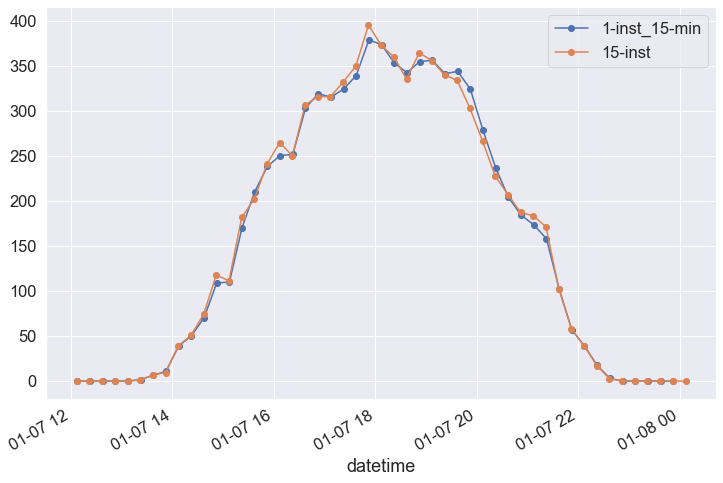

In [44]:
ax = weather.resample('15T').mean().shift(freq='450s')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o', figsize=(12, 8))
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].shift(freq='7min').plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

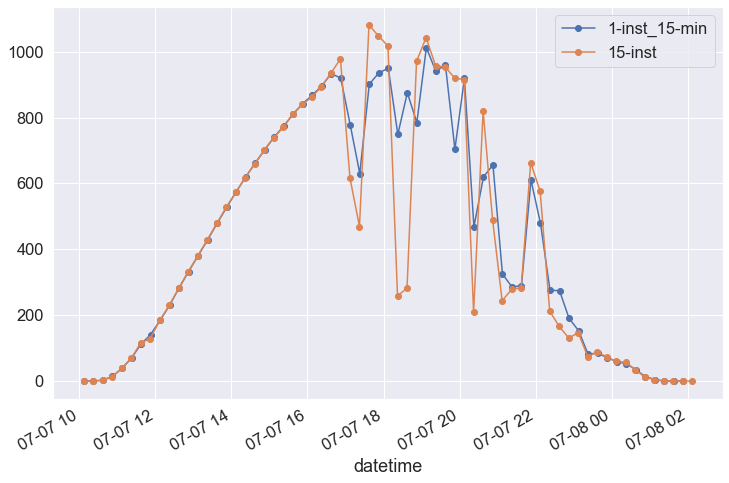

In [45]:
ax = weather.resample('15T').mean().shift(freq='450s')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o', figsize=(12, 8))
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].shift(freq='7min').plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

In [46]:
weather.resample('15T').mean()[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-07 12:00:00+00:00,0.000000,0.726667,0.080000,-6.500000,4.206667
2010-01-07 12:15:00+00:00,0.000000,0.766667,0.086667,-6.500000,4.486667
2010-01-07 12:30:00+00:00,0.000000,0.866667,0.060000,-6.400000,3.780000
2010-01-07 12:45:00+00:00,0.000000,1.000000,0.120000,-6.366667,3.420000
2010-01-07 13:00:00+00:00,0.000000,1.093333,1.280000,-6.300000,3.086667
2010-01-07 13:15:00+00:00,1.566667,0.980000,5.173333,-6.300000,3.726667
2010-01-07 13:30:00+00:00,6.473333,1.106667,10.946667,-6.213333,2.980000
2010-01-07 13:45:00+00:00,10.846667,1.286667,15.506667,-6.080000,3.066667
2010-01-07 14:00:00+00:00,39.033333,1.673333,45.026667,-5.973333,3.246667


# save output
Save the files we need to run SolarFarmer

In [47]:
# month = 'allmonths'
# output_dir = pathlib.Path(f'instantaneous_{month}')
# output_dir.mkdir(exist_ok=False)  # <-- January is already done

In [ ]:
# weather5inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_5-inst.tab', sep='\t')
# weather5inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_5-inst_60-min.tab', sep='\t')

In [ ]:
# weather15inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_15-inst.tab', sep='\t')
# weather15inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_15-inst_60-min.tab', sep='\t')

In [ ]:
# weather30inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_30-inst.tab', sep='\t')
# weather30inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_30-inst_60-min.tab', sep='\t')

In [ ]:
# weather60inst = weather[weather.index.minute.isin([30])].shift(freq='-30min')
# weather60inst['2017-01-07 06:00':'2017-01-07 18:00']

In [ ]:
# weather60inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_60-inst.tab', sep='\t')

# Time Averaged
This is the original clipping error problem.

In [48]:
# weather.dropna().to_csv(output_dir / f'NIST_{month}-2017_1-min.tab', sep='\t')
weather5min = weather.resample('5T').mean()  # .dropna().to_csv(output_dir / f'NIST_{month}-2017_5-min.tab', sep='\t')
weather15min = weather.resample('15T').mean()  # .dropna().to_csv(output_dir / f'NIST_{month}-2017_15-min.tab', sep='\t')
weather30min = weather.resample('30T').mean()  # .dropna().to_csv(output_dir / f'NIST_{month}-2017_30-min.tab', sep='\t')
weather60min = weather.resample('H').mean()  # .dropna().to_csv(output_dir / f'NIST_{month}-2017_60-min.tab', sep='\t')